# Conditional DCGAN

## Imports

In [0]:
import os, time, random,itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import cv2

## Load data

In [0]:
IMAGE_SIZE = 28
onehot = np.eye(10)
noise_ = np.random.normal(0, 1, (10, 1, 1, 100))
fixed_noise_ = noise_
fixed_label_ = np.zeros((10, 1))
#用于最后显示十组图像
for i in range(9):
    fixed_noise_ = np.concatenate([fixed_noise_, noise_], 0)
    temp = np.ones((10, 1)) + i
    fixed_label_ = np.concatenate([fixed_label_, temp], 0)
fixed_label_ = onehot[fixed_label_.astype(np.int32)].reshape((100, 1, 1, 10))
batch_size = 100

#设置一个全局的计数器
global_step = tf.Variable(0, trainable=False)
#设置学习率
lr = tf.train.exponential_decay(0.0002, global_step, 500, 0.95, staircase=True)
#加载数据集Batch大小：100
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])


def leaky_relu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions fo

## Generator

In [0]:
def Generator(x, labels, Training=True, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        #初始化参数
        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)
        #把数据和标签进行连接
        concat = tf.concat([x, labels], 3)
        #第一次反卷积,卷积核大小为7*7，输出维度256
        out_1 = tf.layers.conv2d_transpose(concat, 256, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W, bias_initializer=b)
        out_1 = tf.layers.batch_normalization(out_1, training=Training)#batch norm
        out_1 = leaky_relu(out_1, 0.2)
         #第二次反卷机，卷积核大小为5*5，输出维度128
        out_2 = tf.layers.conv2d_transpose(out_1, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)
         #第三次反卷机，卷积核大小5*5，输出维度1
        out_3 = tf.layers.conv2d_transpose(out_2, 1, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_3 = tf.nn.tanh(out_3)
        return out_3

## Discriminator

In [0]:
def Discriminator(x, real, Training=True, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        #初始化参数
        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)
        #把数据和标签进行连接
        concat = tf.concat([x, real], 3)
        #第一次卷积 卷积核为5*5 输出维度为128
        out_1 = tf.layers.conv2d(concat, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_1 = leaky_relu(out_1, 0.2)
        # 第二次卷积 卷积核为5*5 输出维度256
        out_2 = tf.layers.conv2d(out_1, 256, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)
        #第三次卷积，卷积和为7*7，输出维度为1
        out_3 = tf.layers.conv2d(out_2, 1, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W)
        logits = tf.nn.sigmoid(out_3)
        return logits, out_3

## Set cDCGAN

In [0]:
#一共迭代20次
step = 15

### Placeholder

In [0]:
x = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 1))
noise = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
labels = tf.placeholder(tf.float32, shape=(None, 1, 1, 10))
real = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 10))
Training = tf.placeholder(dtype=tf.bool)

## Loss Function

In [0]:
# 运行生成网络哦
G_noise = Generator(noise, labels, Training)
# 运行判别网络
D_real, D_real_logits = Discriminator(x, real, Training)
D_fake, D_fake_logits = Discriminator(G_noise, real, Training, reuse=True)
# 计算每个网络的损失函数
#算判别器真值的损失函数
Dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
#算判别器噪声生成图片的损失函数
Dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
#损失函数求和
Dis_loss = (Dis_loss_real + Dis_loss_fake) / 2
#计算生成器的损失函数
Gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))
# 提取每个网络的变量
tf_vars = tf.trainable_variables()
Dis_vars = [var for var in tf_vars if var.name.startswith('Discriminator')]
Gen_vars = [var for var in tf_vars if var.name.startswith('Generator')]
# 调整参数 设计是用来控制计算流图的，给图中的某些计算指定顺序
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optim = tf.train.AdamOptimizer(lr, beta1=0.5)#寻找全局最优点的优化算法，引入了二次方梯度校正 衰减率0.5
    D_optim = optim.minimize(Dis_loss, global_step=global_step, var_list=Dis_vars)#优化更新训练的模型参数，也可以为全局步骤(global step)计数
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(Gen_loss, var_list=Gen_vars)#寻找全局最优点的优化算法，引入了二次方梯度校正 衰减率0.5

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d instead.


## Training Pipeline

In [0]:
# 开启一个session，
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
#对MNIST做一下处理
train_set = (mnist.train.images - 0.5) / 0.5
train_label = mnist.train.labels
for i in range(step):
    Gen_losses = []
    Dis_losses = []
    i_start_time = time.time()
    index = random.sample(range(0, train_set.shape[0]), train_set.shape[0])
    new_set = train_set[index]
    new_label = train_label[index]
    for j in range(new_set.shape[0] // batch_size):
        #对判别器进行更新
        x_ = new_set[j*batch_size:(j+1)*batch_size]
        label_ = new_label[j*batch_size:(j+1)*batch_size].reshape([batch_size, 1, 1, 10])
        real_ = label_ * np.ones([batch_size, IMAGE_SIZE, IMAGE_SIZE, 10])
        noise_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_d_, _ = sess.run([Dis_loss, D_optim], {x: x_, noise: noise_, real: real_, labels: label_, Training: True})
        #对生成器进行更新
        noise_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        y_ = np.random.randint(0, 9, (batch_size, 1))
        label_ = onehot[y_.astype(np.int32)].reshape([batch_size, 1, 1, 10])
        real_ = label_ * np.ones([batch_size, IMAGE_SIZE, IMAGE_SIZE, 10])
        loss_g_, _ = sess.run([Gen_loss, G_optim], {noise: noise_, x: x_, real: real_, labels: label_, Training: True})
        #计算训练过程中的损失函数
        errD_fake = Dis_loss_fake.eval({noise: noise_, labels: label_, real: real_, Training: False})
        errD_real = Dis_loss_real.eval({x: x_, labels: label_, real: real_, Training: False})
        errG = Gen_loss.eval({noise: noise_, labels: label_, real: real_, Training: False})
        Dis_losses.append((errD_fake + errD_real)
        Gen_losses.append(errG)
    #print('判别器损失函数: %.6f, 生成器损失函数: %.6f' % (np.mean(Dis_losses), np.mean(Gen_losses)))
    print("EPOCH {} ...".format(i+1))
    print("D_loss = {:.3f}    G_loss = {:.3f}".format(np.mean(Dis_losses),np.mean(Gen_losses)))

EPOCH 1 ...
D_loss = 1.715    G_loss = 1.198
EPOCH 2 ...
D_loss = 1.458    G_loss = 1.448
EPOCH 3 ...
D_loss = 1.640    G_loss = 1.184
EPOCH 4 ...
D_loss = 1.721    G_loss = 1.049
EPOCH 5 ...
D_loss = 1.759    G_loss = 0.925
EPOCH 6 ...
D_loss = 1.926    G_loss = 1.054
EPOCH 7 ...
D_loss = 1.842    G_loss = 0.987
EPOCH 8 ...
D_loss = 2.087    G_loss = 1.170
EPOCH 9 ...
D_loss = 2.091    G_loss = 1.205
EPOCH 10 ...
D_loss = 1.871    G_loss = 0.868
EPOCH 11 ...
D_loss = 1.914    G_loss = 0.947
EPOCH 12 ...
D_loss = 1.986    G_loss = 1.208
EPOCH 13 ...
D_loss = 1.802    G_loss = 0.832
EPOCH 14 ...
D_loss = 1.727    G_loss = 0.976
EPOCH 15 ...
D_loss = 2.226    G_loss = 1.257


## Visualization

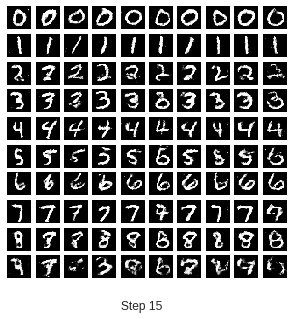

In [0]:
def show_result(num_epoch, show = True, save = False):
    test_images = sess.run(G_noise, {noise: fixed_noise_, labels: fixed_label_, Training: False})
    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (IMAGE_SIZE, IMAGE_SIZE)), cmap='gray')
    label = 'Step {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
        
    if show:
        plt.show()
    else:
        plt.close()
        
        
noise_ = np.random.normal(0, 1, (10, 1, 1, 100))
fixed_noise_ = noise_
fixed_label_ = np.zeros((10, 1))
#用于最后显示十组图像
for i in range(9):
    fixed_noise_ = np.concatenate([fixed_noise_, noise_], 0)
    temp = np.ones((10, 1)) + i
    fixed_label_ = np.concatenate([fixed_label_, temp], 0)
fixed_label_ = onehot[fixed_label_.astype(np.int32)].reshape((100, 1, 1, 10))
batch_size = 100


show_result(15)